In [1]:
import pandas as pd

total_data = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv")
total_data.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


Paso 2: Procesamiento de datos

Transformación categórica a numérica

In [2]:
total_data["is_spam"] = total_data["is_spam"].apply(lambda x: 1 if x else 0).astype(int)
total_data.head()


,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,1
1,https://www.hvper.com/,1
2,https://briefingday.com/m/v4n3i4f3,1
3,https://briefingday.com/n/20200618/m#commentform,0
4,https://briefingday.com/fan,1


Podemos contar fácilmente cuántos casos de cada clase tenemos para analizar si el conjunto de datos está equilibrado o no:

In [3]:
total_data.shape

print(f"Spam: {len(total_data.loc[total_data.is_spam == 1])}")
print(f"No spam: {len(total_data.loc[total_data.is_spam == 0])}")



Spam: 696
No spam: 2303


In [4]:
total_data = total_data.drop_duplicates()
total_data = total_data.reset_index(inplace = False, drop = True)
total_data.shape

(2369, 2)

Procesamiento del texto:

Para poder entrenar el modelo es necesario aplicar antes un proceso de transformación al texto. Comenzamos transformando el texto a minúsculas y eliminando signos de puntuación y caracteres especiales:

In [5]:
import regex as re

def preprocess_text(text):
    # Eliminar cualquier caracter que no sea una letra (a-z) o un espacio en blanco ( )
    text = re.sub(r'[^a-z ]', " ", text)
    
    # Eliminar espacios en blanco
    text = re.sub(r'\s+[a-zA-Z]\s+', " ", text)
    text = re.sub(r'\^[a-zA-Z]\s+', " ", text)

    # Reducir espacios en blanco múltiples a uno único
    text = re.sub(r'\s+', " ", text.lower())

    # Eliminar tags
    text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)

    return text.split()

total_data["url"] = total_data["url"].apply(preprocess_text)
total_data.head()



,url,is_spam
0,"[https, briefingday, us, list, manage, com, un...",1
1,"[https, www, hvper, com]",1
2,"[https, briefingday, com, v, i]",1
3,"[https, briefingday, com, m, commentform]",0
4,"[https, briefingday, com, fan]",1


El siguiente paso es la lemmatización del texto, que es el proceso de simplificación de las palabras a su forma base o canónica, de manera que palabras con diferentes formas pero el mismo núcleo semántico se traten como una sola palabra. 

Eliminaremos también las stopwords, que son palabras que consideramos irrelevantes para el análisis de texto porque aparece con mucha frecuencia en el lenguaje y no aporta información significativa

In [6]:
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
download("wordnet")
lemmatizer = WordNetLemmatizer()

download("stopwords")
stop_words = stopwords.words("english")

def lemmatize_text(words, lemmatizer = lemmatizer):
    tokens = [lemmatizer.lemmatize(word) for word in words]
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if len(word) > 3]
    return tokens

total_data["url"] = total_data["url"].apply(lemmatize_text)
total_data.head()

[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,url,is_spam
0,"[http, briefingday, list, manage, unsubscribe]",1
1,"[http, hvper]",1
2,"[http, briefingday]",1
3,"[http, briefingday, commentform]",0
4,"[http, briefingday]",1


Una nube de palabras es una representación visual de las palabras que componen un texto, donde el tamaño de cada palabra indica su frecuencia o importancia en dicho texto.

Esta representación visual permite identificar rápidamente los términos o conceptos más relevantes o repetidos en un conjunto de datos, ya que las palabras más frecuentes o significativas sobresalen por su tamaño

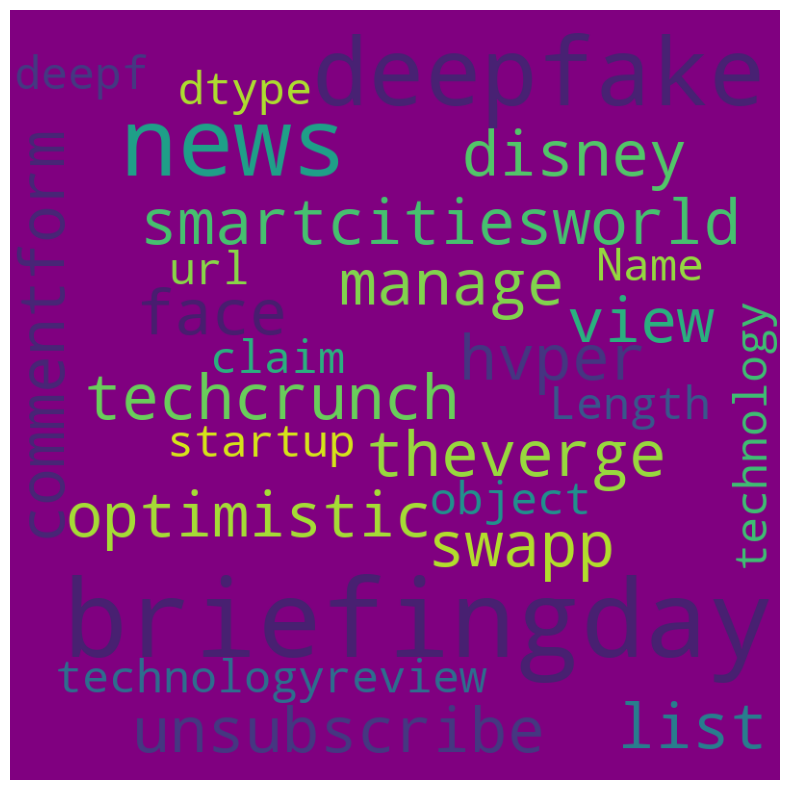

In [7]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(width = 800, height = 800, background_color = "purple", max_words = 1000, min_font_size = 20, random_state = 42)\
    .generate(str(total_data["url"]))

fig = plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

El último paso antes de entrenar el modelo es convertirlo en números, ya que los modelos no pueden entrenar con categorías textuales

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

tokens_list = total_data["url"]
tokens_list = [" ".join(tokens) for tokens in tokens_list]

vectorizer = TfidfVectorizer(max_features = 5000, max_df = 0.8, min_df = 5)
X = vectorizer.fit_transform(tokens_list).toarray()
y = total_data["is_spam"]

X[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


Paso 3: Construye un SVM

In [10]:
from sklearn.svm import SVC

model = SVC(kernel = "linear", random_state = 42)
model.fit(X_train, y_train)

from sklearn.svm import SVC

model = SVC(kernel = "linear", random_state = 42)
model.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

Al especificar kernel="linear" en un modelo de SVM, estás entrenando el modelo para encontrar un límite de decisión lineal que separe las clases en el espacio de características. Esto es útil cuando los datos son linealmente separables, es decir, cuando las clases pueden ser separadas efectivamente por una línea recta en el espacio de características.

In [11]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

Cuando utilizas un modelo SVM para clasificación, el modelo predice la clase a la que pertenece cada muestra de X_test. En tu caso, parece que estás realizando una tarea de clasificación binaria, donde las clases son representadas por True o False.



Si quiero que los valores predichos sean números enteros en lugar de valores booleanos (True o False), puedes usar el método .astype(int) para convertir los valores booleanos en enteros

In [12]:
y_pred_int = y_pred.astype(int)
print(y_pred_int)

[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]


In [13]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.9514767932489452

In [14]:
from pickle import dump

dump(model, open("/workspaces/Proyecto-de-NLP/models/SVM_classifier_linear_42.sav", "wb"))

Paso 4: Optimiza el modelo anterior

Después de entrenar el SVM, optimiza sus hiperparámetros utilizando un grid search o un random search.

In [15]:
import numpy as np
from sklearn.model_selection import GridSearchCV

hyperparams = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "kernel": ["linear", "poly", "rbf", "sigmoid", "precomputed’"],
    "degree": [1, 2, 3, 4, 5],
    "gamma": ["scale", "auto"]
}

# We initialize the random search
grid = GridSearchCV(model, hyperparams, scoring = "accuracy", cv = 5)
grid

GridSearchCV(cv=5, estimator=SVC(kernel='linear', random_state=42),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'degree': [1, 2, 3, 4, 5], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid',
                                    'precomputed’']},
             scoring='accuracy')

In [16]:
grid.fit(X_train, y_train)

print(f"Best hyperparameters: {grid.best_params_}")

Best hyperparameters: {'C': 1000, 'degree': 1, 'gamma': 'auto', 'kernel': 'poly'}


/home/vscode/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:542: FitFailedWarning: 
350 fits failed out of a total of 1750.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
350 fits failed with the following error:
Traceback (most recent call last):
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/base.py", line 1344, in wrapper
    estimator._validate_params()
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/vscode/.l

Aquí está el significado de cada hiperparámetro:

C: Es el parámetro de regularización. Controla el equilibrio entre maximizar el margen y minimizar el error de clasificación. Un valor más alto de C significa un ajuste más estricto a los datos de entrenamiento.

degree: Este hiperparámetro es específico para kernels polinómicos en SVM. Define el grado del polinomio. Un valor de grado más alto indica un modelo más complejo.

gamma: Es un parámetro del kernel. Controla la influencia de un solo ejemplo de entrenamiento, con valores más altos que indican una influencia más grande. Un valor de 'auto' indica que se utilizará 1/n_features.

kernel: Especifica el tipo de kernel a utilizar en el SVM. En este caso, el kernel es "poly", lo que significa que se está utilizando un kernel polinómico.

In [17]:
# Optimizamos el modelo con los parametos encontrados 

opt_model = SVC(C = 1000, degree = 1, gamma = "auto", kernel = "poly", random_state = 42)
opt_model.fit(X_train, y_train)
y_pred = opt_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.9620253164556962

Podemos observas que el modelo ha mejorado 

In [19]:
from pickle import dump

dump(model, open("/workspaces/Proyecto-de-NLP/models/SVM_classifier_Optimizado.sav", "wb"))